In [26]:
import scipy.io
anno_box = scipy.io.loadmat('/home/yuxuan/gpnn/tmp/hico/hico_20160224_det/anno_bbox.mat')

In [17]:
#anno_box is a dictionary of hico_detect dataset
print(anno_box.keys())
#keys are "bbox_train","bbox_test","list_action","__header__","__globals__","__version__"

print(anno_box["bbox_train"].shape)
# totally 38118 training images
print(anno_box["bbox_test"].shape)
# totally 9615 test images

print(anno_box["list_action"].shape)
# contains objects and actions

['__header__', 'list_action', '__globals__', 'bbox_train', 'bbox_test', '__version__']
(1, 38118)
(1, 9658)
(600, 1)


In [18]:
import numpy as np

bbox_train = anno_box['bbox_train']

def collect_hoi_stats(bbox):
    stats = np.zeros(600)
    for idx in range(bbox['filename'].shape[1]):
        for i_hoi in range(bbox['hoi'][0, idx]['id'].shape[1]):
            hoi_id = bbox['hoi'][0, idx]['id'][0, i_hoi][0, 0]
            stats[int(hoi_id)-1] += 1

    return stats

# return appearence of each hoi in datasets, try to find rare hoi
stats = collect_hoi_stats(bbox_train) 

### anno_box
<p align="center"><img width="40%" src="tmp/img/Screenshot from 2020-12-06 11-53-46.png"></p> 

### hoi
#### corresponding hoi action Id, bounding box information
<p align="center"><img width="25%" src="tmp/img/Screenshot from 2020-12-06 12-00-20.png"></p> 

### action Id
#### filtered by object, and denotes which action interacted on the object
<p align="center"><img width="50%" src="tmp/img/Screenshot from 2020-12-06 12-18-54.png"></p> 

### bboxhuman: 
#### bounding box points for human in image
<p align="center"><img width="30%" src="tmp/img/Screenshot from 2020-12-06 12-01-28.png"></p> 

### bboxobject
#### bounding box points for object in image
<p align="center"><img width="20%" src="tmp/img/Screenshot from 2020-12-06 12-01-48.png"></p> 

### original image
<p align="center"><img width="40%" src="tmp/img/HICO_test2015_00000001.jpg"></p> 

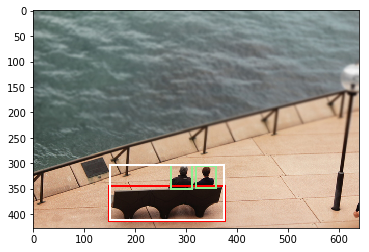

In [35]:
# visualize the hico dataset: use HICO_test2015_00000001.jpg

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np

im = np.array(Image.open('tmp/img/HICO_test2015_00000001.jpg'), dtype=np.uint8)

# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(im)

# Create a Rectangle patch
rect_obj = patches.Rectangle((148,345),376-148,414-345,linewidth=2,edgecolor='r',facecolor='none')
rect_h1 = patches.Rectangle((320,306),359-320,349-306,linewidth=2,edgecolor='lightgreen',facecolor='none')
rect_h2 = patches.Rectangle((270,303),311-270,350-303,linewidth=2,edgecolor='lightgreen',facecolor='none')
rect_h3 = patches.Rectangle((150,303),374-150,412-303,linewidth=2,edgecolor='white',facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect_obj)
ax.add_patch(rect_h1)
ax.add_patch(rect_h2)
ax.add_patch(rect_h3)

plt.show()

In [22]:
import pickle
import numpy as np

# /tmp/hico/processed/hico_data_background_49/ is saving path, which should be used for the GPNN
# saved feature: edge and node in .npy, other information like boxes and classes are in .p
data = pickle.load(open( "/home/yuxuan/gpnn/tmp/hico/processed/hico_data_background_49/HICO_train2015_00000004.p", "rb" ))
edge_features = np.load("/home/yuxuan/gpnn/tmp/hico/processed/hico_data_background_49/HICO_train2015_00000004_edge_features.npy")
node_features = np.load("/home/yuxuan/gpnn/tmp/hico/processed/hico_data_background_49/HICO_train2015_00000004_node_features.npy")

In [25]:
# features extraction
# finetune.py
import feature_extraction.metadata as metadata
import feature_extraction.roi_feature_model as roi_feature_model
import torch.utils.data
import torch.autograd
import torch
import torchvision
import os
import shutil
import argparse
import time

feature_type = 'resnet'
input_h, input_w = 224, 224 # Image should be resized

hico_path = "/home/yuxuan/gpnn/tmp/hico"

# path to save the features (used to compute the input of GPNN)
feature_path = os.path.join(hico_path, 'processed', 'features_background_49')
if not os.path.exists(feature_path):
    os.makedirs(feature_path)
        
image_list = list()     
image_list_file = os.path.join(hico_path, 'trainval.txt')
with open(image_list_file) as f:
    for line in f.readlines():
        image_list.append(line.strip())
        
# build resnet-152 model for feature extraction
feature_network = roi_feature_model.Resnet152(num_classes=len(metadata.action_classes))
feature_network = torch.nn.DataParallel(feature_network).cuda()
# should load the best model, which is tuned in the fine_tune.py

transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225]),])


# Read detection results
det_res_path = os.path.join(hico_path, 'hico_detect_trainvaltest_detections.pkl')
with open(det_res_path, 'r') as f:
    # detection results: [class_num][img_num][detection_num][x1, y1, x2, y2, score]
    det_res = pickle.load(f)
        
# hardcoding of classes        
classes = ['__background__',  # always index 0
               'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat',
               'traffic_light', 'fire_hydrant', 'stop_sign', 'parking_meter', 'bench', 'bird', 'cat', 'dog', 'horse',
               'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports_ball', 'kite', 'baseball_bat', 'baseball_glove',
               'skateboard', 'surfboard', 'tennis_racket', 'bottle', 'wine_glass', 'cup', 'fork', 'knife', 'spoon',
               'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot_dog', 'pizza', 'donut',
               'cake', 'chair', 'couch', 'potted_plant', 'bed', 'dining_table', 'toilet', 'tv', 'laptop', 'mouse',
               'remote', 'keyboard', 'cell_phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book',
               'clock', 'vase', 'scissors', 'teddy_bear', 'hair_drier', 'toothbrush']

In [77]:
# roi extract features

import feature_extraction.extract_roi_features as extract_roi_features

total_idx = 0
skip_idx = 0
used_img_list = list()
for i_image, img_name in enumerate(image_list):
    print(img_name)
    total_idx += 1
    # Extracted bounding boxes and classes
    det_boxes_all = np.empty((0, 4))
    det_classes_all = list()
    for c in range(1, len(classes)): # except position 0 because it is "__background__"
        for detection in det_res[c][i_image]:
            if detection[4] > 0.7:
                det_boxes_all = np.vstack((det_boxes_all, np.array(detection[:4])[np.newaxis, ...]))
                det_classes_all.append(c)
    if len(det_classes_all) == 0: # image action not in the classes
        print(' skipping')
        skip_idx += 1
        continue
        
    used_img_list.append(img_name + '\n')
    
    edge_classes = list()
    
    for person_i, person_c in enumerate(det_classes_all):
        if person_c == 1:
            for obj_i, obj_c in enumerate(det_classes_all):
                if obj_c == 1:
                    continue
                combined_box = extract_roi_features.combine_box(det_boxes_all[person_i, :], det_boxes_all[obj_i, :])
                det_boxes_all = np.vstack((det_boxes_all, combined_box))
                edge_classes.append(0)
    det_classes_all.extend(edge_classes)

    # Get image feature by applying VGG to ROI (roi_vgg)
    image_path = os.path.join(hico_path, 'hico_20160224_det', "images",'train2015',img_name + '.jpg')
    assert os.path.exists(image_path)
    original_img = scipy.misc.imread(image_path, mode='RGB')

    roi_features = np.zeros((det_boxes_all.shape[0], 1000))
                        

    for i_box in range(det_boxes_all.shape[0]):
        roi = det_boxes_all[i_box, :].astype(int)
        roi_image = original_img[roi[1]:roi[3]+1, roi[0]:roi[2]+1, :]
        # plt.imshow(roi_image)
        # plt.show()
        roi_image = transform(cv2.resize(roi_image, (input_h, input_w), interpolation=cv2.INTER_LINEAR))
        roi_image = torch.autograd.Variable(roi_image.unsqueeze(0)).cuda()
        feature, _ = feature_network(roi_image)
        roi_features[i_box, ...] = feature.data.cpu().numpy()

    np.save(os.path.join(feature_path, '{}_classes'.format(img_name)), det_classes_all)
    np.save(os.path.join(feature_path, '{}_boxes'.format(img_name)), det_boxes_all)
    np.save(os.path.join(feature_path, '{}_features'.format(img_name)), roi_features)
                            

HICO_train2015_00000001


/home/yuxuan/anaconda3/envs/gpnn/lib/python2.7/site-packages/ipykernel_launcher.py:39: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


ValueError: could not broadcast input array from shape (200) into shape (1000)

In [28]:
hoi_classes = ['board', 'direct', 'exit', 'fly', 'inspect', 'load', 'ride', 'sit_on', 'wash', 'no_interaction',
                'carry', 'hold', 'inspect', 'jump', 'hop_on', 'park', 'push', 'repair', 'ride', 'sit_on', 'straddle',
                'walk', 'wash', 'no_interaction', 'chase', 'feed', 'hold', 'pet', 'release', 'watch', 'no_interaction',
                'board', 'drive', 'exit', 'inspect', 'jump', 'launch', 'repair', 'ride', 'row', 'sail', 'sit_on',
                'stand_on', 'tie', 'wash', 'no_interaction', 'carry', 'drink_with', 'hold', 'inspect', 'lick', 'open',
               'pour', 'no_interaction', 'board', 'direct', 'drive', 'exit', 'inspect', 'load', 'ride', 'sit_on',
               'wash', 'wave', 'no_interaction', 'board', 'direct', 'drive', 'hose', 'inspect', 'jump', 'load', 'park',
               'ride', 'wash', 'no_interaction', 'dry', 'feed', 'hold', 'hug', 'kiss', 'pet', 'scratch', 'wash',
               'chase', 'no_interaction', 'carry', 'hold', 'lie_on', 'sit_on', 'stand_on', 'no_interaction', 'carry',
               'lie_on', 'sit_on', 'no_interaction', 'feed', 'herd', 'hold', 'hug', 'kiss', 'lasso', 'milk', 'pet',
               'ride', 'walk', 'no_interaction', 'clean', 'eat_at', 'sit_at', 'no_interaction', 'carry', 'dry', 'feed',
               'groom', 'hold', 'hose', 'hug', 'inspect', 'kiss', 'pet', 'run', 'scratch', 'straddle', 'train', 'walk',
               'wash', 'chase', 'no_interaction', 'feed', 'groom', 'hold', 'hug', 'jump', 'kiss', 'load', 'hop_on',
               'pet', 'race', 'ride', 'run', 'straddle', 'train', 'walk', 'wash', 'no_interaction', 'hold', 'inspect',
               'jump', 'hop_on', 'park', 'push', 'race', 'ride', 'sit_on', 'straddle', 'turn', 'walk', 'wash',
               'no_interaction', 'carry', 'greet', 'hold', 'hug', 'kiss', 'stab', 'tag', 'teach', 'lick',
               'no_interaction', 'carry', 'hold', 'hose', 'no_interaction', 'carry', 'feed', 'herd', 'hold', 'hug',
               'kiss', 'pet', 'ride', 'shear', 'walk', 'wash', 'no_interaction', 'board', 'drive', 'exit', 'load',
               'ride', 'sit_on', 'wash', 'no_interaction', 'control', 'repair', 'watch', 'no_interaction', 'buy',
               'cut', 'eat', 'hold', 'inspect', 'peel', 'pick', 'smell', 'wash', 'no_interaction', 'carry', 'hold',
               'inspect', 'open', 'wear', 'no_interaction', 'buy', 'carry', 'cut', 'eat', 'hold', 'inspect', 'peel',
               'pick', 'smell', 'no_interaction', 'break', 'carry', 'hold', 'sign', 'swing', 'throw', 'wield',
               'no_interaction', 'hold', 'wear', 'no_interaction', 'feed', 'hunt', 'watch', 'no_interaction', 'clean',
               'lie_on', 'sit_on', 'no_interaction', 'inspect', 'lie_on', 'sit_on', 'no_interaction', 'carry', 'hold',
               'open', 'read', 'no_interaction', 'hold', 'stir', 'wash', 'lick', 'no_interaction', 'cut', 'eat',
               'hold', 'smell', 'stir', 'wash', 'no_interaction', 'blow', 'carry', 'cut', 'eat', 'hold', 'light',
               'make', 'pick_up', 'no_interaction', 'carry', 'cook', 'cut', 'eat', 'hold', 'peel', 'smell', 'stir',
               'wash', 'no_interaction', 'carry', 'hold', 'read', 'repair', 'talk_on', 'text_on', 'no_interaction',
               'check', 'hold', 'repair', 'set', 'no_interaction', 'carry', 'drink_with', 'hold', 'inspect', 'pour',
               'sip', 'smell', 'fill', 'wash', 'no_interaction', 'buy', 'carry', 'eat', 'hold', 'make', 'pick_up',
               'smell', 'no_interaction', 'feed', 'hold', 'hose', 'hug', 'kiss', 'hop_on', 'pet', 'ride', 'walk',
               'wash', 'watch', 'no_interaction', 'hug', 'inspect', 'open', 'paint', 'no_interaction', 'hold', 'lift',
               'stick', 'lick', 'wash', 'no_interaction', 'block', 'catch', 'hold', 'spin', 'throw', 'no_interaction',
               'feed', 'kiss', 'pet', 'ride', 'watch', 'no_interaction', 'hold', 'operate', 'repair', 'no_interaction',
               'carry', 'hold', 'inspect', 'no_interaction', 'carry', 'cook', 'cut', 'eat', 'hold', 'make',
               'no_interaction', 'carry', 'clean', 'hold', 'type_on', 'no_interaction', 'assemble', 'carry', 'fly',
               'hold', 'inspect', 'launch', 'pull', 'no_interaction', 'cut_with', 'hold', 'stick', 'wash', 'wield',
               'lick', 'no_interaction', 'hold', 'open', 'read', 'repair', 'type_on', 'no_interaction', 'clean',
               'open', 'operate', 'no_interaction', 'control', 'hold', 'repair', 'no_interaction', 'buy', 'cut', 'eat',
               'hold', 'inspect', 'peel', 'pick', 'squeeze', 'wash', 'no_interaction', 'clean', 'hold', 'inspect',
               'open', 'repair', 'operate', 'no_interaction', 'check', 'pay', 'repair', 'no_interaction', 'buy',
               'carry', 'cook', 'cut', 'eat', 'hold', 'make', 'pick_up', 'slide', 'smell', 'no_interaction', 'clean',
               'hold', 'move', 'open', 'no_interaction', 'hold', 'point', 'swing', 'no_interaction', 'carry', 'cook',
               'cut', 'eat', 'hold', 'make', 'no_interaction', 'cut_with', 'hold', 'open', 'no_interaction', 'clean',
               'repair', 'wash', 'no_interaction', 'carry', 'flip', 'grind', 'hold', 'jump', 'pick_up', 'ride',
               'sit_on', 'stand_on', 'no_interaction', 'adjust', 'carry', 'hold', 'inspect', 'jump', 'pick_up',
               'repair', 'ride', 'stand_on', 'wear', 'no_interaction', 'adjust', 'carry', 'grind', 'hold', 'jump',
               'ride', 'stand_on', 'wear', 'no_interaction', 'hold', 'lick', 'wash', 'sip', 'no_interaction', 'block',
               'carry', 'catch', 'dribble', 'hit', 'hold', 'inspect', 'kick', 'pick_up', 'serve', 'sign', 'spin',
               'throw', 'no_interaction', 'hold', 'stand_under', 'stop_at', 'no_interaction', 'carry', 'drag', 'hold',
               'hug', 'load', 'open', 'pack', 'pick_up', 'zip', 'no_interaction', 'carry', 'drag', 'hold', 'inspect',
               'jump', 'lie_on', 'load', 'ride', 'stand_on', 'sit_on', 'wash', 'no_interaction', 'carry', 'hold',
               'hug', 'kiss', 'no_interaction', 'carry', 'hold', 'inspect', 'swing', 'no_interaction', 'adjust', 'cut',
               'hold', 'inspect', 'pull', 'tie', 'wear', 'no_interaction', 'hold', 'operate', 'repair',
               'no_interaction', 'clean', 'flush', 'open', 'repair', 'sit_on', 'stand_on', 'wash', 'no_interaction',
               'brush_with', 'hold', 'wash', 'no_interaction', 'install', 'repair', 'stand_under', 'stop_at',
               'no_interaction', 'direct', 'drive', 'inspect', 'load', 'repair', 'ride', 'sit_on', 'wash',
               'no_interaction', 'carry', 'hold', 'lose', 'open', 'repair', 'set', 'stand_under', 'no_interaction',
               'hold', 'make', 'paint', 'no_interaction', 'fill', 'hold', 'sip', 'toast', 'lick', 'wash',
               'no_interaction', 'feed', 'hold', 'pet', 'watch', 'no_interaction']

obj_hoi_index = [(0, 0), (161, 170), (11, 24), (66, 76), (147, 160), (1, 10), (55, 65), (187, 194), (568, 576),
                 (32, 46), (563, 567), (326, 330), (503, 506), (415, 418), (244, 247), (25, 31), (77, 86), (112, 129),
                 (130, 146), (175, 186), (97, 107), (314, 325), (236, 239), (596, 600), (343, 348), (209, 214), (577, 584),
                 (353, 356), (539, 546), (507, 516), (337, 342), (464, 474), (475, 483), (489, 502), (369, 376), (225, 232),
                 (233, 235), (454, 463), (517, 528), (534, 538), (47, 54), (589, 595), (296, 305), (331, 336), (377, 383),
                 (484, 488), (253, 257), (215, 224), (199, 208), (439, 445), (398, 407), (258, 264), (274, 283), (357, 363),
                 (419, 429), (306, 313), (265, 273), (87, 92), (93, 96), (171, 174), (240, 243), (108, 111), (551, 558),
                 (195, 198), (384, 389), (394, 397), (435, 438),(364, 368), (284, 290), (390, 393), (408, 414), (547, 550),
                 (450, 453), (430, 434), (248, 252), (291, 295),(585, 588), (446, 449), (529, 533), (349, 352), (559, 562)
                ]

action_classes = ['adjust', 'assemble', 'block', 'blow', 'board', 'break', 'brush_with', 'buy', 'carry', 'catch',
                   'chase', 'check', 'clean', 'control', 'cook', 'cut', 'cut_with', 'direct', 'drag', 'dribble',
                   'drink_with', 'drive', 'dry', 'eat', 'eat_at', 'exit', 'feed', 'fill', 'flip', 'flush', 'fly',
                   'greet', 'grind', 'groom', 'herd', 'hit', 'hold', 'hop_on', 'hose', 'hug', 'hunt', 'inspect',
                   'install', 'jump', 'kick', 'kiss', 'lasso', 'launch', 'lick', 'lie_on', 'lift', 'light', 'load',
                  'lose', 'make', 'milk', 'move', 'no_interaction', 'open', 'operate', 'pack', 'paint', 'park', 'pay',
                  'peel', 'pet', 'pick', 'pick_up', 'point', 'pour', 'pull', 'push', 'race', 'read', 'release',
                   'repair', 'ride', 'row', 'run', 'sail', 'scratch', 'serve', 'set', 'shear', 'sign', 'sip', 'sit_at',
                   'sit_on', 'slide', 'smell', 'spin', 'squeeze', 'stab', 'stand_on', 'stand_under', 'stick', 'stir',
                   'stop_at', 'straddle', 'swing', 'tag', 'talk_on', 'teach', 'text_on', 'throw', 'tie', 'toast',
                   'train', 'turn', 'type_on', 'walk', 'wash', 'watch', 'wave', 'wear', 'wield', 'zip']
action_coco = action_classes[2]
obj_interval = obj_hoi_index[1]
hois = hoi_classes[obj_interval[0] - 1 : obj_interval[1]]

In [29]:
action_coco

'block'

In [30]:
obj_interval

(161, 170)

In [31]:
hois = hoi_classes[obj_interval[0] - 1 : obj_interval[1]]

In [33]:
hois.index(action_coco)

ValueError: 'block' is not in list